# Module Development and Testing: `lmp-md-systems` Repository

## Imports

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
plt.style.use('seaborn-paper')
plt.style.use('seaborn-white')
plt.style.use('seaborn-ticks')
import json
import re
import sys
sys.path.append("/Users/philip_ii/Desktop/lmp-md-systems/lib")
import pyrdf

### `pylmps.py`

#### `str_array_dict_to_json`

In [31]:
def str_array_dict_to_json(str_arr_dict, to_file_path):
    """ Saves a Python dictionary with the format <str: numpy array> to disk
    as a .json file.
    
    All values (numpy arrays) of the dictionary are assumed to have the same size
    as each array represents one column in the underlying dataframe encoded by the
    passed-in Python dictionary.
    
    Args:
        str_arr_dict (dict): data stored in the form of a Python dictionary with
            the key-value pairs structured as followed:
                <variable/column name> (str): <values/entries> (1-D numpy array)
        to_file_path (str): absolute/relative path to the file where the Python
            dictionary will be written to disk in JSON format. Should end with ".json".
    Returns:
        None: output written to file.
    """
    df = pd.DataFrame.from_dict(str_arr_dict)
    df.to_json(to_file_path)

In [25]:
test_dict = {}
test_dict["x"] = np.array(list(range(10)))
test_dict["y"] = np.ones(10)

test_dict

{'x': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'y': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

In [30]:
df = pd.DataFrame.from_dict(test_dict)
df.to_json("./test.json")

In [32]:
str_arr_dict_to_json(test_dict, "/Users/philip_ii/Desktop/test.json")

#### `read_json_to_dict`

In [40]:
def read_json_to_dict(file_path, params=True):
    """ Reads a JSON file to Python dictionary.
    
    Args:
        file_path (str): absolute/relative path to the .json file.
        params (bool): whether or not the parsed file is params.json.
            If True: the file is structured like a simple Python dict.
            If False: the file encodes a pandas DataFrame and is most
                likely a product of calling pylmps.str_array_dict_to_json
                or pandas.DataFrame.to_json.
            
            Defaults to True.
    
    Returns:
        dict: Python dictionary equivalent of the json file with format:
            <variable> (str): <value> (float or numpy array)
    """
    if params:
        with open(file_path, "r") as file:
            output_dict = json.load(file)
    else:
        df = pd.read_json(path_or_buf=file_path)
        output_dict = df.to_dict(orient='list')
    return output_dict

In [21]:
with open("/Users/philip_ii/nerschome/test/data/40563331/params.json", "r") as file:
    parameters = json.load(file)
parameters

{'lx': 35.3553390593274,
 'ly': 35.3553390593274,
 'rhoA': 0.08,
 'rhoP': 0.004,
 'f_active': 8,
 'rcut': 1.12246204830937,
 'dt': 0.005,
 'ctA': 100,
 'ctP': 5}

In [35]:
read_json_to_dict("/Users/philip_ii/nerschome/test/data/40563331/params.json")

{'lx': 35.3553390593274,
 'ly': 35.3553390593274,
 'rhoA': 0.08,
 'rhoP': 0.004,
 'f_active': 8,
 'rcut': 1.12246204830937,
 'dt': 0.005,
 'ctA': 100,
 'ctP': 5}

In [39]:
df1 = pd.read_json(path_or_buf="/Users/philip_ii/Desktop/test.json")
df1.to_dict(orient='list')

{'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'y': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [44]:
read_json_to_dict("../../test.json", params=False)

{'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'y': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

### `pyrdf.py`

#### `read_rdf_arrays`

In [7]:
def read_rdf_arrays(file_path, num_bin=100, cumul=True):
    """ Read RDF data from file into numpy arrays.
    
    It is assumed that there are four columns
    in the .rdf file, that the same file records time-averaged, cumulative RDF data, and that it is 
    of proper format generated using lammps fix ave/time function.

    @param FILE_PATH: A string representing the path from the CWD of this notebook to the .rdf
        file to be parsed.

    @return 2 numpy arrays ordered by:
        1) r values corresponding to the center of each bin
        2) radial distribution function g(r) densities
    """

    file = open(file_path, 'r')

    r_lst = []
    rdf_lst = []
    if not cumul:
        one_rdf_scan = []

    curr_ln = file.readline()
    start_read = False
    first_pass = True
    curr_bin = 1

    while curr_ln != '':
        # process current line of text
        curr_ln = curr_ln.rstrip('\n')
        curr_ln_split = re.split(r'\s', curr_ln)
        
        # first line of data reached
        if len(curr_ln_split) == 4:
            start_read = True

        if start_read:
            # if the rdf data is cumulative with one scan only
            if cumul:
                r_lst.append(float(curr_ln_split[1]))
                rdf_lst.append(float(curr_ln_split[2]))
            # if the rdf data consist of multiple time-averaged scans
            else:
                # reset variables for next time scan
                if curr_bin > num_bin:
                    rdf_lst.append(one_rdf_scan)
                    curr_ln_split = re.split(r'\s', file.readline().rstrip('\n'))
                    one_rdf_scan = []
                    curr_bin = 1
                    first_pass = False
                
                one_rdf_scan.append(float(curr_ln_split[2]))
                curr_bin += 1
                
                if first_pass:
                    r_lst.append(float(curr_ln_split[1]))

        curr_ln = file.readline()
    
    if not cumul:
        rdf_lst.append(one_rdf_scan)
    file.close()

    r_arr = np.array(r_lst)
    rdf_arr = np.array(rdf_lst)

    return r_arr, rdf_arr

In [8]:
r_arr, rdf_arr = read_rdf_arrays("/Users/philip_ii/Desktop/test/data/rdf_sample_mean.rdf", cumul=False)

#### `test_rdf_convergence`

In [56]:
def test_rdf_convergence(bin_num, sample_mean_file):
    """ Test the convergence of sample means of radial distribution function using
    the Central Limit Theorem.
    """
    r_arr, rdf_sample_means = read_rdf_arrays(sample_mean_file, cumul=False)
    
    num_scans = rdf_sample_means.shape[0]
    running_var_lst = []
    
    for n in range(2, num_scans+1):
        one_var_across_r = np.var(rdf_sample_means[:n], axis=0)
        var_at_bin = one_var_across_r[bin_num-1]
        running_var_lst.append(var_at_bin)
    
    running_var_arr = np.array(running_var_lst)
    scan_num = np.arange(2, num_scans+1)
    
    return scan_num, running_var_arr

In [4]:
r_arr, rdf_sample_means = read_rdf_arrays("/Users/philip_ii/Desktop/test/data/rdf_sample_mean.rdf", cumul=False)

In [5]:
rdf_sample_means

array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.0268769, 0.340181 , 0.770062 , 1.4695   , 1.9177   ,
        2.60468  , 1.84331  , 1.48757  , 1.13976  , 1.33664  , 1.38724  ,
        1.81277  , 1.16203  , 0.75877  , 1.01573  , 1.05493  , 1.13966  ,
        0.829679 , 0.905478 , 0.701163 , 0.840336 , 1.02828  , 1.14589  ,
        1.13766  , 1.35765  , 1.11061  , 1.32168  , 0.971338 , 0.807701 ,
        0.800113 , 0.625958 , 0.555384 , 0.542716 , 0.747405 , 0.58393  ,
        0.698716 , 1.06759  , 1.3021   , 1.41163  , 1.75399  , 2.25673  ,
        1.8162   , 1.305    , 1.52746  , 1.4195   , 0.694614 , 0.595045 ,
        0.392701 , 0.494881 , 0.493682

In [51]:
rdf_sample_means[:2]

array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.0268769, 0.340181 , 0.770062 , 1.4695   , 1.9177   ,
        2.60468  , 1.84331  , 1.48757  , 1.13976  , 1.33664  , 1.38724  ,
        1.81277  , 1.16203  , 0.75877  , 1.01573  , 1.05493  , 1.13966  ,
        0.829679 , 0.905478 , 0.701163 , 0.840336 , 1.02828  , 1.14589  ,
        1.13766  , 1.35765  , 1.11061  , 1.32168  , 0.971338 , 0.807701 ,
        0.800113 , 0.625958 , 0.555384 , 0.542716 , 0.747405 , 0.58393  ,
        0.698716 , 1.06759  , 1.3021   , 1.41163  , 1.75399  , 2.25673  ,
        1.8162   , 1.305    , 1.52746  , 1.4195   , 0.694614 , 0.595045 ,
        0.392701 , 0.494881 , 0.493682

In [50]:
rdf_sample_means.shape[0]

9

In [53]:
np.var(rdf_sample_means, axis=0)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00155811, 0.03761585, 0.12791536, 0.32406309,
       0.12257869, 0.18166197, 0.1056823 , 0.07636634, 0.10716966,
       0.10534157, 0.12158443, 0.12293527, 0.13223291, 0.17020147,
       0.07207324, 0.07000598, 0.05110271, 0.07196306, 0.1179264 ,
       0.18890006, 0.08918793, 0.08233279, 0.1056791 , 0.04994378,
       0.07394375, 0.10096994, 0.07559305, 0.09845172, 0.11851419,
       0.11839404, 0.06939004, 0.02305827, 0.042262  , 0.02275095,
       0.04549641, 0.07218267, 0.05020196, 0.04369556, 0.05276625,
       0.15214053, 0.23806483, 0.14152114, 0.05687682, 0.07956

In [55]:
np.arange(2, 10)

array([2, 3, 4, 5, 6, 7, 8, 9])

In [82]:
# slurm-id: 41295478 12M steps
scan_num, running_var = test_rdf_convergence(50, "/Users/philip_ii/nersc/cscratch1/sd/p_yc_tu/test/data/41295478/rdf_sample_mean.rdf")

In [83]:
running_var

array([0.01387943, 0.00947759, 0.01082975, 0.01327975, 0.01142414,
       0.0178789 , 0.02045894, 0.04303609, 0.03905307, 0.03628363,
       0.03432805, 0.03774173, 0.04204601, 0.04148195, 0.03939435,
       0.03794023, 0.04242771, 0.04110792, 0.04130951, 0.03934242,
       0.03775941, 0.03745649, 0.03600389, 0.03708994, 0.03600168,
       0.03469679, 0.03495342, 0.0337856 , 0.03265981, 0.03216622,
       0.03373678, 0.03305902, 0.03315663, 0.03231953, 0.0319945 ,
       0.03150432, 0.03067876, 0.03012281, 0.02996908, 0.02944854,
       0.02911566, 0.02959699, 0.02893924, 0.02866918, 0.02814065,
       0.03110061, 0.03049203, 0.02988742, 0.03116984, 0.03326998,
       0.03267803, 0.03206353, 0.03150037, 0.03190914, 0.03167289,
       0.0311601 , 0.03065197, 0.03072781, 0.03022031, 0.03040762,
       0.03023053, 0.03005494, 0.02959832, 0.02941161, 0.02935444,
       0.02925311, 0.02882996, 0.02897443, 0.02862102, 0.0284303 ,
       0.02836293, 0.02896944, 0.02858216, 0.02823279, 0.02789

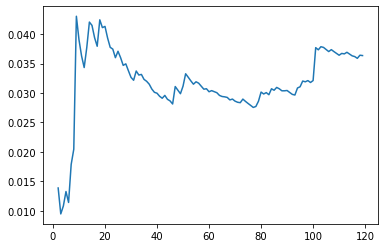

In [84]:
plt.plot(scan_num, running_var)

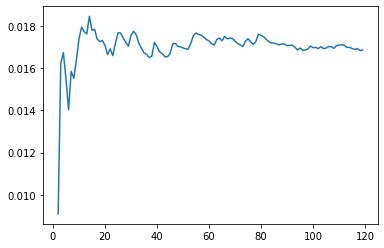

In [78]:
total_running_var = 0
for b in range(60, 101):
    temp_scan_num, running_var = test_rdf_convergence(b, "/Users/philip_ii/nersc/cscratch1/sd/p_yc_tu/test/data/41295478/rdf_sample_mean.rdf")
    total_running_var += running_var

total_running_var = total_running_var/41
plt.plot(temp_scan_num, total_running_var)

In [3]:
def extract_element_2D(idx, arr2d):
    """"""
    if idx >= arr2d.shape[1]:
        print("Invalid index. Index exceeds length of inner array(s).")
        return None
    
    extracted = [arr1d[idx] for arr1d in arr2d]
    
    return np.array(extracted)

In [4]:
def calc_running_abs_error(at_bin, rdf_samples_file):
    """"""
    r_arr, rdfs = read_rdf_arrays(rdf_samples_file, cumul=False)
    
    rdf_at_bin = extract_element_2D(at_bin-1, rdfs)
    num_scans = len(rdf_at_bin)
    scans = np.arange(1, num_scans+1)
    
    best_estimate = np.mean(rdf_at_bin)
    running_avg = np.cumsum(rdf_at_bin) / scans
    running_abs_error = np.abs(running_avg - best_estimate)
    
    return scans, running_abs_error

In [39]:
def plot_rdf_convergence(Nfreq, at_bin, rdf_samples_file, xlim=(), ylim=(), refline_shift=2):
    """ Test the convergence of sample means of radial distribution function using
    the Central Limit Theorem.
    """
    scans, running_abs_error = calc_running_abs_error(at_bin, rdf_samples_file)
    
    n = Nfreq*scans
    refline = (10**refline_shift) * np.sqrt(1./n)
    
    plt.figure()
    plt.plot(n, running_abs_error, label=r"$\epsilon(n)$")    # = \sum_{i=n_{min}}^ng_i(r)$")
    plt.plot(n, refline, label=r"$\propto 1/\sqrt{n}$")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Number of Timesteps (n)")
    plt.ylabel(r"Absolute Error $\epsilon(n)$")
    plt.title("Running Absolute Error of RDF at Bin {}".format(at_bin))
    plt.legend()
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

68


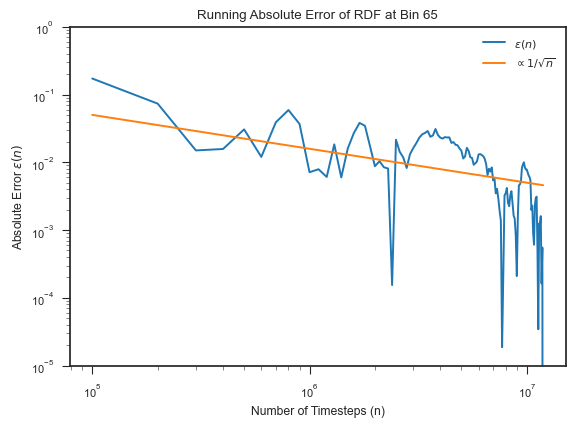

In [61]:
# Npassive = 20, 12M steps
at_bin = int((20/29)*100)
Nfreq = 100000
rdf_samples_file = "/Users/philip_ii/nersc/cscratch1/sd/p_yc_tu/test/data/41295478/rdf_sample_mean.rdf"
print(at_bin)

plot_rdf_convergence(Nfreq, 65, rdf_samples_file, ylim=(1e-5, 1e0), refline_shift=1.2)

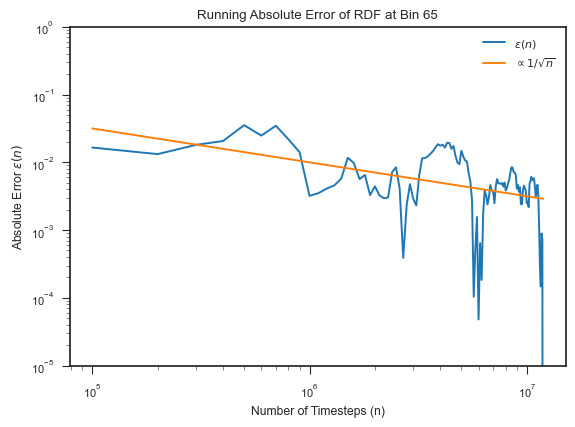

In [62]:
# Npassive = 45, 12M steps
rdf_samples_file = "/Users/philip_ii/nersc/cscratch1/sd/p_yc_tu/test/data/41450175/rdf_sample_mean.rdf"

plot_rdf_convergence(Nfreq, 65, rdf_samples_file, ylim=(1e-5, 1e0), refline_shift=1)

In [ ]:
# RELATIVE ERROR

In [23]:
r_arr, rdfs = read_rdf_arrays(rdf_samples_file, cumul=False)

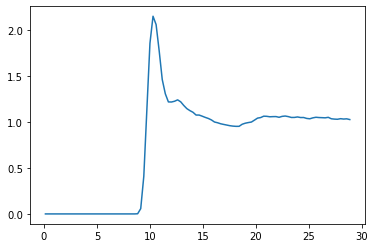

In [27]:
rdf = np.mean(rdfs, axis=0)
plt.plot(r_arr, rdf)

In [17]:
extract_element_2D(99, rdf_sample_means)

array([1.39594 , 1.02456 , 1.34989 , 1.21175 , 0.801826, 1.05459 ,
       1.20774 , 1.66521 , 1.09313 ])

In [6]:
rdf_sample_means

array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.0268769, 0.340181 , 0.770062 , 1.4695   , 1.9177   ,
        2.60468  , 1.84331  , 1.48757  , 1.13976  , 1.33664  , 1.38724  ,
        1.81277  , 1.16203  , 0.75877  , 1.01573  , 1.05493  , 1.13966  ,
        0.829679 , 0.905478 , 0.701163 , 0.840336 , 1.02828  , 1.14589  ,
        1.13766  , 1.35765  , 1.11061  , 1.32168  , 0.971338 , 0.807701 ,
        0.800113 , 0.625958 , 0.555384 , 0.542716 , 0.747405 , 0.58393  ,
        0.698716 , 1.06759  , 1.3021   , 1.41163  , 1.75399  , 2.25673  ,
        1.8162   , 1.305    , 1.52746  , 1.4195   , 0.694614 , 0.595045 ,
        0.392701 , 0.494881 , 0.493682